# Coronavirus disease (COVID-19) detection in Chest X-Ray images

## Module Four - code
CAPSTONE 1 - AIDI 1003, Course Facilitator:
Uzair Ahmad

# Group Members: 
Robin Manchanda (100811316)
Vinith Babu Muruganantham (100806012) 
Nishant Balasubramanian (100808971)


# Importing the required libraries

In [49]:
import pandas as pd# to work with dataframes
import numpy as np # library for linear algebra processing
import matplotlib.pyplot as plt # for plotting the data and images
import os # helps to with directories
import cv2
from random import shuffle # used to shuffle the data randomly
import glob as gb # used to import the image  
import random
from sklearn.model_selection import train_test_split #helps to split the data into training and test set
from dask_ml.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score # to calculate the accuracy of the model
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, plot_confusion_matrix# to evaluate the model performanc
from sklearn.model_selection import cross_val_score# use to assess the model accuracy with K-fold cv 
import pickle# to store the trained model
from sklearn import metrics# to calulate the auc
import warnings
from dask.distributed import Client
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model# to create the deep learning model
from tensorflow.keras.optimizers import Adam# optimizers to find the parameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator# for data augmentation
from tensorflow.keras.applications import VGG16, ResNet101# deep learning models
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv2D# to create output layers

# 1. Acquiring the data
Computer vision is one of the hottest topics in the AI industry. For this project, we are using x-ray scans to detect the covid19. We have acquired images from the GitHub repository and the Kaggle platform. But before performing any task on the X-Ray images, it is almost every time crucial to preprocess the image into a suitable input format for the chosen algorithms. 

## 	1.1 Basics of Image: 
Before diving deep into image processing, it is vital to know some specifications of the image. There are dimensions such as width*height. Width and height are the numbers of pixels in horizontal and vertical of the image, and multiplying both gives the total number of pixels for the given image. The pixel, which denotes a point in the picture, is an integer or multiple integers and this depends upon the type of the image like a single channel (Gray Scale) or multi-channel (RGB, RGBA) image. 
 


In [3]:
data_dir = "./Covid_dataset" # This is the directory of our dataset

In [4]:
covid_dir = data_dir + "/"+ os.listdir(data_dir)[0]# This is the directory of our covid scans
normal_dir = data_dir + "/"+ os.listdir(data_dir)[1]# This is the directory of our normal scans
print("Data_directory",data_dir,"\n", "Covid_directory",covid_dir,"\n","Normal_directory",normal_dir)

Data_directory ./Covid_dataset 
 Covid_directory ./Covid_dataset/Covid 
 Normal_directory ./Covid_dataset/Normal


In [5]:
# gb.glob(path) will return the list comprises of all files(complete directory) in the given path
covid_images = len(gb.glob(pathname= data_dir + "/" + "Covid" + "/*"))
normal_images = len(gb.glob(pathname= data_dir + "/" + "Normal" + "/*"))
print(f"Number of covid positive's X-ray scans: {covid_images} \n", f"Number of Normal patient's X-ray scans:{normal_images}")

Number of covid positive's X-ray scans: 495 
 Number of Normal patient's X-ray scans:500


In [7]:
y_map = {'Normal': 0, 'Covid': 1} # dict to map covid scans to 1 and normal scans to 0.
def str_code(stri):
    return y_map[stri]

## 1.2 Reading and Resizing an Image:
For most of the algorithms, we need to convert these images into NumPy arrays. For this purpose, we have used the imread() method of the OpenCV library. As the x-ray scans are greyscaled images, OpenCV converted it into (m, h,w) where m is the number of examples and w,h is the number of pixels in width and height. It is always good to have all the images in the same dimension as the total number of pixels in each image represents the number of features. Hence, we have to resize it for that we used the cv2.resize(), which converts the picture into specified width and height.




In [8]:
def image_arr(d_dir,image_size=224):
    """This function will convert the images to numpy array.
        It take the directory as input and convert all the images in this directory to a multi dimensional numpy array."""
    
    x = []
    y = []
    x1 = []
    y1 = []
    for folder in os.listdir(d_dir): # loop for the folder
        i=1
        print('{} folders found'.format(len(os.listdir(d_dir))))
        for file in gb.glob(pathname= d_dir + "/" + folder + "/*"): # loop for the images
            tot_img = len(gb.glob(pathname= d_dir + "/" + folder + "/*"))
            if i==1:
                print('{} images found in {} folder'.format(tot_img, folder))
#             print(file)
            arr = cv2.imread(file,0)# it'll convert the image into numpy array
            arr1 = cv2.imread(file)
#             print(arr.shape)
            arr = cv2.resize(arr, dsize = (image_size,image_size)) # resizing it to (224,224)
            arr1 = cv2.resize(arr1, dsize = (image_size,image_size))
#             print(arr.shape)
            x.append(arr)
            y.append(str_code(folder)) #Appending 1 for covid, 0 for normal
            x1.append(arr1)
            y1.append(str_code(folder))
#             print(np.array(x).shape)
            perc = i/tot_img*100# To print how much processing is completed
            if round(perc,1)%10 ==0:
                  print('{}% of {} images processed'.format(round(perc,1),folder))
            i+=1
            
                
            
    x = np.array(x)
    y = np.array(y)    
    x1 = np.array(x1)
    y1 = np.array(y1)
    return x,y, x1, y1

    

In [9]:
x,y, x1, y1 = image_arr(data_dir)

2 folders found
495 images found in Covid folder
20.0% of Covid images processed
40.0% of Covid images processed
60.0% of Covid images processed
80.0% of Covid images processed
100.0% of Covid images processed
2 folders found
500 images found in Normal folder
10.0% of Normal images processed
20.0% of Normal images processed
30.0% of Normal images processed
40.0% of Normal images processed
50.0% of Normal images processed
60.0% of Normal images processed
70.0% of Normal images processed
80.0% of Normal images processed
90.0% of Normal images processed
100.0% of Normal images processed


In [10]:
x.shape # (m,num_px, num_px) where m is number of images fo both covid and normal, num_px shows height and weight

(995, 224, 224)

In [11]:
x1.shape

(995, 224, 224, 3)

In [12]:
y.shape# (m,) where m is number of examples

(995,)

In [13]:
y1.shape

(995,)

Text(0, 0.5, 'Number of X-ray scans')

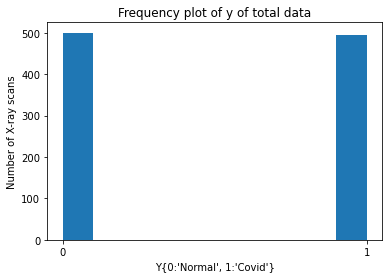

In [14]:
plt.title("Frequency plot of y of total data")
plt.hist(y)
plt.xticks([0,1])
plt.xlabel("Y{0:'Normal', 1:'Covid'}")
plt.ylabel('Number of X-ray scans')

# 2. Exploratory Data Analysis:
EDA comprises brief analyses about our dataset, which helps our modelling process to proceed further. It also facilitates us to find some data insights which may not be visible directly. Generally, in EDA, some interesting patterns are identified after checking the distribution of independent variables and dependent variables.


In [15]:
x_covid = x[:covid_images] #Slicing the array to get covid scans array.
x_normal = x[covid_images:covid_images+normal_images]#Slicing the array to get normal scans array.
y_covid = y[:covid_images]
y_normal = y[covid_images:covid_images+normal_images]

In [16]:
print(x_covid.shape, y_covid.shape,x_normal.shape,y_normal.shape)

(495, 224, 224) (495,) (500, 224, 224) (500,)


In Image classification, we can also perform the EDA such as:

##     2.1 Comparison between different classes by the raw images:
The images and their label are selected randomly from each class and are visualized by using the imshow() function of the matplotlib library.


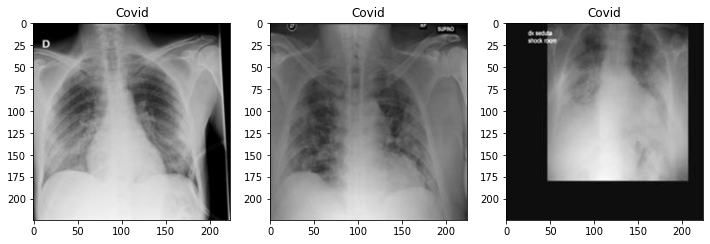

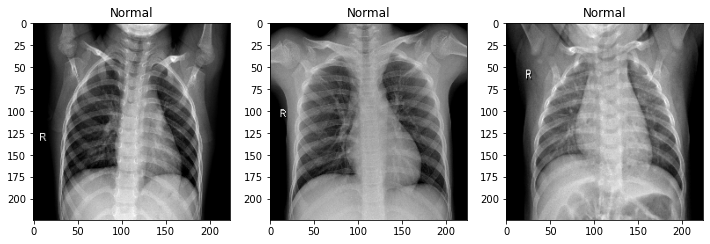

In [17]:
# It'll create a list of three elements choosen randomly from np array
norm_lis = np.random.choice(np.arange(x_normal.shape[0]),3, replace=False)
cov_lis = np.random.choice(np.arange(x_covid.shape[0]),3, replace=False)

for row in range(2):
    plt.figure(figsize=(12,8))
    for col in range(3):
        if row == 0:
            plt.subplot(2,3,col+1)
            plt.imshow(x_covid[cov_lis[col]], cmap = 'gray')
            plt.title('Covid')
        
        else:
            plt.subplot(2,3,col+1)
            plt.imshow(x_normal[norm_lis[col]], cmap = 'gray')
            plt.title('Normal')
            
    plt.show()

## 2.2 Comparison between mean image:
The NumPy array(matrix) of each image is converted into a feature vector. All the images in the dataset are added to a NumPy array of shape (m,n) where m is the number of examples and n is the total number of features.

The mean concerning the feature for every class is calculated by using the function np.mean() with axis = 0. These arrays are used to visualize the comparison between average images.


In [18]:
def mean(img_arr, title, size = (224, 224)):
    # this function finds the mean of array with axis =0
    mean_img = np.mean(img_arr, axis = 0)
    mean_img = mean_img.reshape(size)
    return mean_img

def std(img_arr, title, size = (224, 224)):
    # this function finds the std deviation of array with axis =0
    std_img = np.std(img_arr, axis = 0)
    std_img = std_img.reshape(size)
    return std_img

In [19]:
norm_mean = mean(x_normal, 'NORMAL')
covid_mean = mean(x_covid, 'COVID')

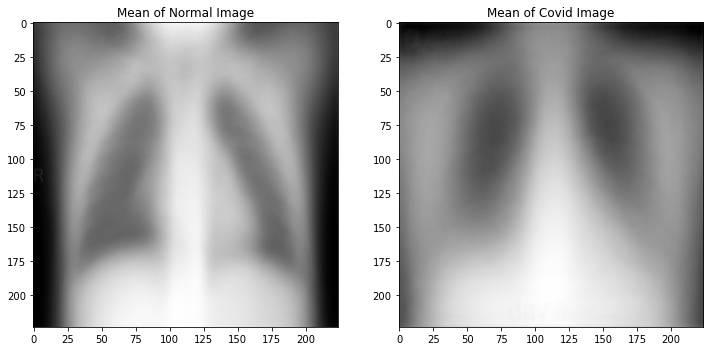

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

ax1.imshow(norm_mean, cmap='gray')
ax1.set_title("Mean of Normal Image")

ax2.imshow(covid_mean, cmap='gray')
ax2.set_title("Mean of Covid Image")

plt.show()

#### The upper images show that mean image of the covid is more blurry than the normal one. 

## 2.3 Visualizing the difference image:

Instead of visualizing both average images, the difference between their mean values is taken and plotted. The number of examples of each class in the training and test dataset is found by plotting a frequency plot graph.



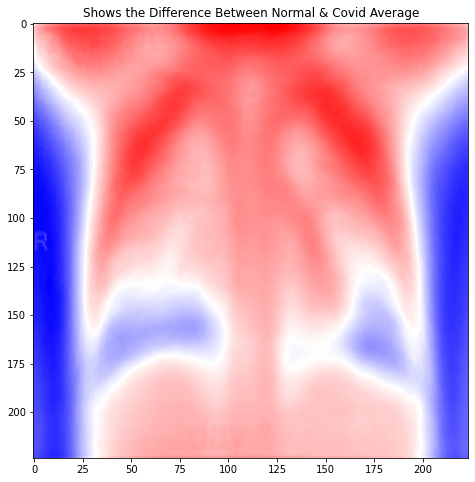

In [21]:
diff_mean = norm_mean - covid_mean
plt.figure(figsize=(12,8))
plt.imshow(diff_mean, cmap='bwr')
plt.title('Shows the Difference Between Normal & Covid Average')
plt.show()

In [22]:
norm_std = std(x_normal, 'NORMAL')
covid_std = std(x_covid, 'COVID')

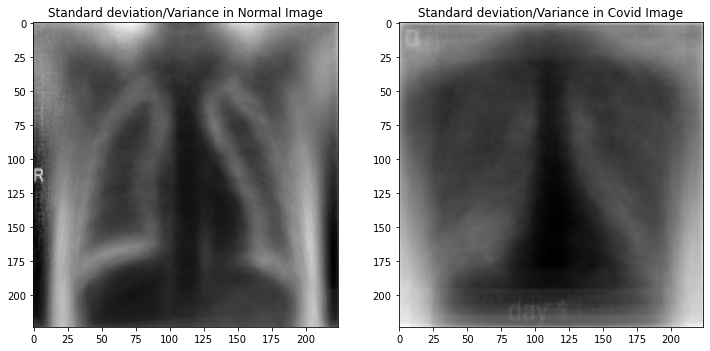

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

ax1.imshow(norm_std, cmap='gray')
ax1.set_title("Standard deviation/Variance in Normal Image")

ax2.imshow(covid_std, cmap='gray')
ax2.set_title("Standard deviation/Variance in Covid Image")

plt.show()

## 2.4 Fast Fourier Transform of Covid and Normal x-ray image

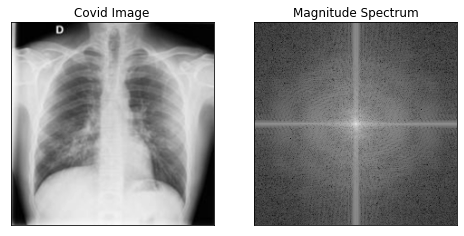

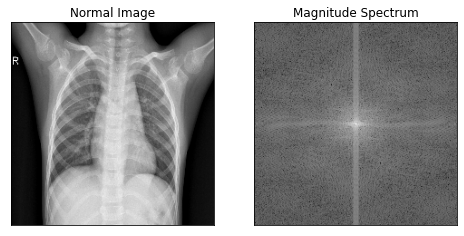

In [24]:

for i in range(1):
    
    plt.figure(figsize=(8,8))
    img = x_covid[i]
    f = np.fft.fft2(img)# converting image to frequency domain by fast fourier transform
    fshift = np.fft.fftshift(f)# shifting the zero frequency to center
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Covid Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    plt.figure(figsize=(8,8))
    img = x_normal[i]
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Normal Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

Finding: The magnitude spectrum shows the magnitude of each frequency that is present in the image. The centre of the magnitude spectrum has shifted to denote the zero frequency i.e DC. We can clearly see that both images have their energy more concentrated at their low frequencies, but it seems that in case of covid, the enegy is more concentrated at low frequencies.

# 3. Splitting the data into training and test data

In [25]:
client = Client(n_workers=4, threads_per_worker=10)
client

Client Scheduler: tcp://127.0.0.1:40959 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 40 Memory: 12.31 GiB


In [26]:
import dask_ml.model_selection as dms
X_train, X_test, y_train, y_test = dms.train_test_split(x,y, test_size=0.33, random_state=42 )

In [27]:
X_train_org, X_test_org, y_train_org, y_test_org = X_train, X_test, y_train, y_test

In [28]:
import dask.array as da
classes = da.unique(y_train).compute()
classes

array([0, 1])

In [29]:
X_train.shape

(666, 224, 224)

Text(0, 0.5, 'Number of X-ray scans')

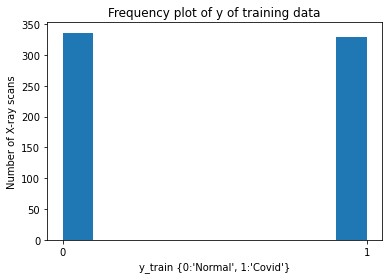

In [30]:
plt.title("Frequency plot of y of training data")
plt.hist(y_train)
plt.xticks([0,1])
plt.xlabel("y_train {0:'Normal', 1:'Covid'}")
plt.ylabel('Number of X-ray scans')

Text(0, 0.5, 'Number of X-ray scans')

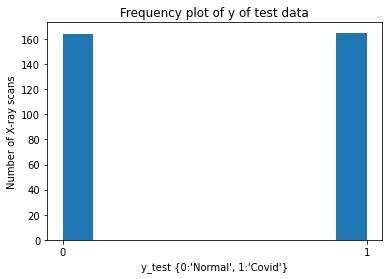

In [31]:
plt.title("Frequency plot of y of test data")
plt.hist(y_test)
plt.xticks([0,1])
plt.xlabel("y_test {0:'Normal', 1:'Covid'}")
plt.ylabel('Number of X-ray scans')

# 4. Data preprocessing
## 4.1 Data Augmentation: 
Data Augmentation is a technique to expand the size of the training dataset without collecting new data. The data/images in the dataset are modified using the following techniques,
•	Shift (Horizontal/Vertical)
•	Zoom
•	Flip (Horizontal/Vertical)
•	Rotate


In [32]:
class data_aug:
    """data_aug class is used to implement the various augmentation techniques.
        There are several methods in this class which help to implement this."""
    def __init__(self,img):
        self.img = img
        
    def vertical_flip(self,flag):#If flag is true it'll flip the image vertically
        if flag:
            new_img = cv2.flip(self.img, 0)
            return new_img
        else:
            return self.img
        
    def horizontal_flip(self,flag):#If flag is true it'll flip the image horizontally
        if flag:
            new_img = cv2.flip(self.img, 1)
            return new_img
        else:
            return self.img
        
    def horizontal_shift(self, ratio=0.0):# This method will perform horizontal shit by using ratio.
        if ratio > 1 or ratio < 0:
            print('Value should be less than 1 and greater than 0')
            return self.img
        ratio = random.uniform(-ratio, ratio)# It'll pick the a number randomly from a uniform dist. between -ratio to ratio.
        h, w = self.img.shape[:2]
        to_shift = w*ratio# how much percentage of width we want to shift
        if ratio > 0:
            new_img = self.img[:, :int(w-to_shift)]# Full height but width from o to (1-ratio)*w
        if ratio < 0:
            new_img = self.img[:, int(-1*to_shift):]# Full height but width from ratio*w till last pixel.
        new_img = cv2.resize(new_img, (h, w), interpolation = cv2.INTER_CUBIC)# interpolation is a use to fill the shifted pixels
        return new_img
    
    def vertical_shift(self, ratio=0.0):# it's almost similar to horizontal shift but we'll work on height here.
        if ratio > 1 or ratio < 0:
            print('Value should be less than 1 and greater than 0')
            return self.img
        ratio = random.uniform(-ratio, ratio)
        h, w = self.img.shape[:2]
        to_shift = h*ratio
        if ratio > 0:
            new_img = self.img[:int(h-to_shift), :]
        if ratio < 0:
            new_img = self.img[int(-1*to_shift):, :]
        new_img = cv2.resize(new_img, (h, w), interpolation = cv2.INTER_CUBIC)
        return new_img
    
    def rotation(self, angle):# Rotate the image by the angle specified
        angle = int(random.uniform(-angle, angle))
        h, w = self.img.shape[:2]
        M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
        new_img = cv2.warpAffine(self.img, M, (w, h))
        return new_img
    
    def zoom(self, value): #zoom the image
        if value > 1 or value < 0:
            print('Value for zoom should be less than 1 and greater than 0')
            return self.img
        value = random.uniform(value, 1)
        h, w = self.img.shape[:2]
        h_taken = int(value*h)
        w_taken = int(value*w)
        h_start = random.randint(0, h-h_taken)# choose a random starting point for the image in between 0 and h-h_taken
        w_start = random.randint(0, w-w_taken)# choose a random starting point for the image in between 0 and h-h_taken
        new_img = self.img[h_start:h_start+h_taken, w_start:w_start+w_taken]# slicing of input image array height as well width
         #                                                                                                                wise.
        new_img = cv2.resize(new_img, (h, w), interpolation = cv2.INTER_CUBIC)
        return new_img
    
    def brightness(self, low, high):# adjust the brightness of image
        value = random.uniform(low, high)
        img_bgr = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)# we can't directly convert the gray image into HSV
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)# HSV is hue,saturation,value. Value is responsible for lighting in  image
        hsv = np.array(hsv, dtype = np.float64)
        hsv[:,:,1] = hsv[:,:,1]*value
        hsv[:,:,1][hsv[:,:,1]>255]  = 255
        hsv[:,:,2] = hsv[:,:,2]*value 
        hsv[:,:,2][hsv[:,:,2]>255]  = 255# it'll make bright pixels more bright
        hsv = np.array(hsv, dtype = np.uint8)
        new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
        return new_img

In [33]:
x_train_aug = []
y_train_aug = []
tot_img = X_train.shape[0]
i=1
print('{} images found in training dataset'.format(tot_img))
for i in range(tot_img):
    """This loop take each image from X_train, and use the methods from img_aug class for data augmentation.
        Here we have taken the data augmentation only for the training dataset, and it'll help to reduce the overfitting.
        As there are large number of features(50176) and less number of observations/examples in our dataset"""
    img_aug = data_aug(X_train[i])
    x_train_aug.append(img_aug.vertical_flip(True))
    y_train_aug.append(y_train[i])
    x_train_aug.append(img_aug.horizontal_flip(True))
    y_train_aug.append(y_train[i])
    x_train_aug.append(img_aug.vertical_shift(0.2))
    y_train_aug.append(y_train[i])
    x_train_aug.append(img_aug.horizontal_shift(0.2))
    y_train_aug.append(y_train[i])
    x_train_aug.append(img_aug.zoom(0.2))
    y_train_aug.append(y_train[i])
    x_train_aug.append(img_aug.rotation(30))
    y_train_aug.append(y_train[i])
    x_train_aug.append(img_aug.brightness(0.5,2))
    y_train_aug.append(y_train[i])
    perc = i/tot_img*100
    if round(perc,1)%10 ==0:
         print('{}% of training images processed'.format(round(perc,1)))
    i+=1



666 images found in training dataset
0.0% of training images processed
20.0% of training images processed
30.0% of training images processed
50.0% of training images processed
70.0% of training images processed
80.0% of training images processed


In [34]:
np.array(y_train_aug).shape

(4662,)

In [35]:
np.array(x_train_aug).shape

(4662, 224, 224)

Text(0, 0.5, 'Number of X-ray scans')

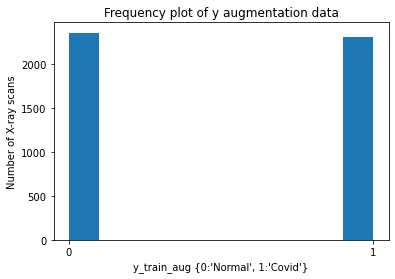

In [36]:
plt.title("Frequency plot of y augmentation data")
plt.hist(y_train_aug)
plt.xticks([0,1])
plt.xlabel("y_train_aug {0:'Normal', 1:'Covid'}")
plt.ylabel('Number of X-ray scans')

## X-ray scans after data augmentation

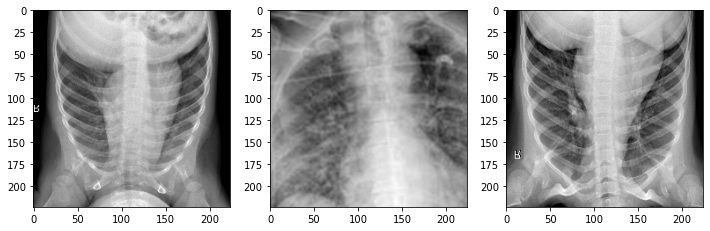

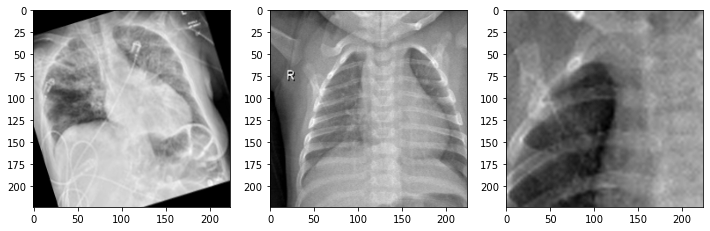

In [37]:
aug_lis = np.random.choice(np.arange(np.array(x_train_aug).shape[0]),6, replace=False)
for row in range(2):
    plt.figure(figsize=(12,8))
    for col in range(3):
        if row == 0:
            plt.subplot(2,3,col+1)
            plt.imshow(np.array(x_train_aug)[aug_lis[col]], cmap = 'gray')
        
        else:
            plt.subplot(2,3,col+1)
            plt.imshow(np.array(x_train_aug)[aug_lis[col+3]], cmap = 'gray')
            
    plt.show()
    


In [38]:
X_train = np.concatenate([X_train,np.array(x_train_aug)], axis =0)# concatenating the augmanted data and training data.
Y_train = np.concatenate([y_train,np.array(y_train_aug)], axis =0)

Text(0, 0.5, 'Number of X-ray scans')

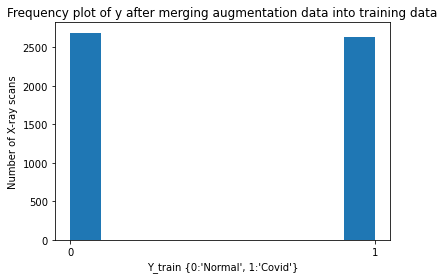

In [39]:
plt.title("Frequency plot of y after merging augmentation data into training data")
plt.hist(Y_train)
plt.xticks([0,1])
plt.xlabel("Y_train {0:'Normal', 1:'Covid'}")
plt.ylabel('Number of X-ray scans')

## 4.2 Rescaling and reshaping :
One common preprocessing step in machine learning is to centre and standardize our dataset, meaning that we subtract the mean of the whole NumPy array from each example, and then divide each entry by the standard deviation of the entire NumPy array. But for picture datasets, it is simpler and more convenient and works well if every row of the data set is divided by 255 (the maximum value of a pixel channel).




In [40]:
def shap_scal(arr):
    """This function helps to rescaling and reshaping"""
    # converts matrix of order (m, num_px, num_px) into feature vector (m, , num_px*num_px), required for ML algorithms.
    x_feat = arr.reshape(arr.shape[0],-1)
    x_resc = x_feat/255 #Scaling the features in between[0,1]
    return x_resc

In [41]:
x_train = shap_scal(X_train)
x_test = shap_scal(X_test)
print(x_train.shape,Y_train.shape, x_test.shape, y_test.shape)

(5328, 50176) (5328,) (329, 50176) (329,)


# 5. Modelling Approach
## 5.1 Machine Learning Algorithms: 
Four classification models such as Logistic Regression, SVM Classifier, Decision Tree, and naïve Bayes have been implemented

### 5.1.1 Logistic Regression: 
It is a linear classifier. But if the number of features is larger than the number of examples, this model might become susceptible to overfitting.  L2 regularization with the value of C=0.2 can be used to reduce overfitting.


In [64]:
model = LogisticRegression(penalty='l2', C = 0.2, max_iter= 100, n_jobs=-1, solver='liblinear')
"""As the number of parameters are very large, regularization(L2) is used to reduce the overfitting.
Lower the value of c, overfitting decreases."""

'As the number of parameters are very large, regularization(L2) is used to reduce the overfitting.\nLower the value of c, overfitting decreases.'

In [65]:
model.fit(x_train, Y_train)

ValueError: 'solver' must be {'lbfgs', 'newton', 'admm', 'gradient_descent', 'proximal_grad'}. Got 'liblinear' instead

In [ ]:
pred = model.predict(x_test)

#### 5.1.1.1 Accuracy
Accuracy score predicts out of the total sample of y_test, how many sample of pred exaclty matches the y_test.

In [ ]:
accuracy_score(y_test, pred)

#### 5.1.1.2 Confusion Matrix
Accuracy can be some time a misleading metric, especially for the imbalanced dataset. Hence to ensure the model performance, and to find the number of images which are misclassified, we evaluated confusion matrix.

In [ ]:
plot_confusion_matrix(model, x_test, y_test)
plt.show()

In this project, we are detecting the coronavirus. Hence, the false-negative becomes very important to assess carefully. If a single positive covid patient is misclassified by the model as a normal person, he can spread the coronavirus in the whole community.

#### 5.1.1.3 Classification Report
It shows the various metrics, such as precision, recall, and f1-score, to evaluate the model performance. In this project, recall will give more information about the model as it uses FALSE NEGATIVE in its calculation.

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
x_processed = shap_scal(x)

#### 5.1.1.4 Ten-fold Cross Validation Accuracy
The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation. If k=10 the dataset will be divided into 10 equal parts and the below process will run 10 times, each time with a different holdout set.

1. Take the group as a holdout or test data set
2. Take the remaining groups as a training data set
3. Fit a model on the training set and evaluate it on the test set
4. Retain the evaluation score and discard the model
5. At the end of the above process Summarize the skill of the model using the sample of model evaluation scores.

In [ ]:
score = cross_val_score(model, x_processed, y.ravel(), cv=10)
print(score)

print('Mean: {} Standard deviaftion: {}'.format(np.mean(score), np.std(score)))

#### 5.1.1.5 Area under ROC curve (AUC)
The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In [ ]:
y_score = model.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])
auc  = metrics.auc(fpr, tpr)
auc

#### 5.1.1.6 Misclassified Images (False Negative and False Positive)

In [ ]:
def confm_img(pred):
    """This function is used to find the images that are misclassified by the model"""
    
    fn = np.logical_and(pred == 0, y_test.ravel()==1)# prediction is normal but in reality he was a covid patient.
    fp = np.logical_and(pred == 1, y_test.ravel()==0)
    tp = np.logical_and(pred == 1, y_test.ravel()==1)
    tn = np.logical_and(pred == 0, y_test.ravel()==0)
    j=0
    for i in (fn,fp):
        
#         print(j)
        if j == 0:
            title = 'False Negative'
            
        else:
            title = 'False Positive'
        
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))
        
        aug_lis = np.random.choice(np.arange(np.array(X_test[i]).shape[0]),3, replace=False)

        ax1.imshow(X_test[i][aug_lis[0]], cmap='gray')
        ax1.set_title(title)

        ax2.imshow(X_test[i][aug_lis[1]], cmap='gray')
        ax2.set_title(title)

        ax3.imshow(X_test[i][aug_lis[2]], cmap='gray')
        ax3.set_title(title)
        
        plt.show()
        j+=1

In [ ]:
confm_img(pred)

### 5.1.2 SVM classifier (Gaussian Kernel): 
For this algorithm, the Gaussian kernel and the low value of C are used. Gaussian kernel helps us to find the nonlinear boundary while the low value of C helps to reduce the overfitting.


In [ ]:
from sklearn.svm import SVC

In [ ]:
model2 = SVC(C = 0.2, kernel= 'rbf', )# Gaussian kernel is used as it can help to find the highly non linear boundaries.

In [ ]:
model2.fit(x_train, Y_train)

#### 5.1.2.1 Accuracy
Accuracy is one metric for evaluating classification models. Accuracy is the number of correct predictions divided by the total number of predictions.

In [ ]:
pred2 = model2.predict(x_test)

accuracy_score(y_test, pred2)

#### 5.1.2.2 Confusion Matrix
SVM with gaussian kernel did a very good job on decreasing the number of FALSE NEGATIVE

In [ ]:
plot_confusion_matrix(model2, x_test, y_test)
plt.show()

#### 5.1.2.3 Classification Report
A text report showing the main classification metrics. Recall value is also increased to 0.97

In [ ]:
print(classification_report(y_test, pred2))

#### 5.1.2.4 Ten-fold Cross Validation Accuracy

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation. If k=10 the dataset will be divided into 10 equal parts and the below process will run 10 times, each time with a different holdout set.

1. Take the group as a holdout or test data set
2. Take the remaining groups as a training data set
3. Fit a model on the training set and evaluate it on the test set
4. Retain the evaluation score and discard the model
5. At the end of the above process Summarize the skill of the model using the sample of model evaluation scores.


In [ ]:
score2 = cross_val_score(model2, x_processed, y.ravel(), cv=10)
score2

In [ ]:
print('Mean: {} Standard deviation: {}'.format(np.mean(score2), np.std(score2)))

#### 5.1.2.5 Area under ROC curve (AUC)

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In [ ]:
y_score = model2.decision_function(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
auc2 = metrics.auc(fpr, tpr)
auc2

#### 5.1.2.6 Misclassified Images (False Negative and False Positive)

In [ ]:
confm_img(pred2)

### 5.1.3 SVM classifier (Linear Kernel):

In [ ]:
model3 = SVC(C = 0.2, kernel= 'linear')

model3.fit(x_train, Y_train)

In [ ]:
pred3 = model3.predict(x_test)

#### 5.1.3.1 Accuracy
Accuracy is the number of correct predictions divided by the total number of predictions.

In [ ]:
accuracy_score(y_test, pred3)

#### 5.1.3.2 Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [ ]:
plot_confusion_matrix(model3, x_test, y_test)
plt.show()


Here, the number of false negative is very high.

#### 5.1.3.3 Classification Report

A text report showing the main classification metrics.

In [ ]:
print(classification_report(y_test, pred3))

#### 5.1.3.4 Ten-fold Cross Validation Accuracy

 The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation. If k=10 the dataset will be divided into 10 equal parts and the below process will run 10 times, each time with a different holdout set.

1. Take the group as a holdout or test data set
2. Take the remaining groups as a training data set
3. Fit a model on the training set and evaluate it on the test set
4. Retain the evaluation score and discard the model
5. At the end of the above process Summarize the skill of the model using the sample of model evaluation scores.

In [ ]:
score3 = cross_val_score(model3, x_processed, y.ravel(), cv=10)
print(score3)

print('Mean: {} Standard deviation: {}'.format(np.mean(score3), np.std(score3)))

#### 5.1.3.5 Area under ROC curve (AUC)

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In [ ]:
y_score = model3.decision_function(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
auc3 = metrics.auc(fpr, tpr)
auc3

#### 5.1.3.6 Misclassified Images (False Negative and False Positive)

In [ ]:
confm_img(pred3)

### 5.1.4 Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model4 = GaussianNB()

In [ ]:
model4.fit(x_train, Y_train)

In [ ]:
pred4 = model4.predict(x_test)

#### 5.1.4.1 Accuracy
Accuracy is the number of correct predictions divided by the total number of predictions.

In [ ]:
accuracy_score(y_test, pred4)

#### 5.1.4.2 Confusion Matrix

In [ ]:
plot_confusion_matrix(model4, x_test, y_test)
plt.show()

Again, the number of false negative is very high.

#### 5.1.4.3 Classification Report
A text report showing the main classification metrics.

In [ ]:
print(classification_report(y_test, pred4))

#### 5.1.4.4 Ten-fold Cross Validation Accuracy

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation. If k=10 the dataset will be divided into 10 equal parts and the below process will run 10 times, each time with a different holdout set.

1. Take the group as a holdout or test data set
2. Take the remaining groups as a training data set
3. Fit a model on the training set and evaluate it on the test set
4. Retain the evaluation score and discard the model
5. At the end of the above process Summarize the skill of the model using the sample of model evaluation scores.

In [ ]:
score4 = cross_val_score(model4, x_processed, y.ravel(), cv=10)
print(score4)

print('Mean: {} Standard deviation: {}'.format(np.mean(score4), np.std(score4)))

#### 5.1.4.5 Area under ROC curve (AUC)

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In [ ]:
y_score = model4.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])
auc4 = metrics.auc(fpr, tpr)
auc4

#### 5.1.4.6 Misclassified Images (False Negative and False Positive)

In [ ]:
confm_img(pred4)

### 5.1.5 Decision Tree Classifier 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model5= DecisionTreeClassifier()

In [ ]:
model5.fit(x_train, Y_train)


In [ ]:
pred5 = model5.predict(x_test)

#### 5.1.5.1 Accuracy
Accuracy is the number of correct predictions divided by the total number of predictions.

In [ ]:
accuracy_score(y_test, pred5)

#### 5.1.5.2 Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [ ]:
plot_confusion_matrix(model5, x_test, y_test)
plt.show()

#### 5.1.5.3 Classification Report
A text report showing the main classification metrics.

In [ ]:
print(classification_report(y_test, pred5))

#### 5.1.5.4 Ten-fold Cross Validation Accuracy

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation. If k=10 the dataset will be divided into 10 equal parts and the below process will run 10 times, each time with a different holdout set.

1. Take the group as a holdout or test data set
2. Take the remaining groups as a training data set
3. Fit a model on the training set and evaluate it on the test set
4. Retain the evaluation score and discard the model
5. At the end of the above process Summarize the skill of the model using the sample of model evaluation scores.

In [ ]:
score5 = cross_val_score(model5, x_processed, y.ravel(), cv=10)
print(score5)

print('Mean: {} Standard deviation: {}'.format(np.mean(score5), np.std(score5)))

#### 5.1.5.5 Area under ROC curve (AUC)

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In [ ]:
y_score = model5.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])
auc5 = metrics.auc(fpr, tpr)
auc5

#### 5.1.5.6 Misclassified Images (False Negative and False Positive)

In [ ]:
confm_img(pred5)

In [ ]:
y1_test.shape

### 5.1.6 Saving trained models using Pickle

In [ ]:
filename1 = 'lr_model.sav'
# pickle.dump(model, open(filename1, 'wb'))
filename2 = 'svc_model.sav'
# pickle.dump(model2, open(filename2, 'wb'))

In [ ]:
filename3 = 'svc_lr_model.sav'
# pickle.dump(model3, open(filename3, 'wb'))
filename4 = 'gnb_model.sav'
# pickle.dump(model4, open(filename4, 'wb'))
filename5 = 'dtc_model.sav'
# pickle.dump(model5, open(filename5, 'wb'))

In [ ]:
model = pickle.load(open(filename1, 'rb'))
model2 = pickle.load(open(filename2, 'rb'))
model3 = pickle.load(open(filename3, 'rb'))
model4 = pickle.load(open(filename4, 'rb'))
model5 = pickle.load(open(filename5, 'rb'))

## 5.2 Deep Learning Algorithms:
Computer vision is one of the areas where DL’s performance is increasing exponentially. The reasons behind why deep learning is doing good in computer vision are as follows:
1.	First, in the case of the image as an input, many input features will cause the model to overfit.
2.	Second, the traditional neural networks have to learn an enormous number of parameters making the computation expensive.

As a solution, convolution neural networks (CNN) are used thanks to its parameter sharing, due to which it does not have too many parameters to learn. Also, CNN has the sparsity of connections: the output depends only on a small number of inputs.


In [ ]:
ip_size= (224,224,3)# input shape of image
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.0001# learning rate

In [ ]:
# splits the data into training and test data
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1, test_size=0.33, random_state=42 )

In [ ]:
train_gen = ImageDataGenerator( # use for data augmentation
    rescale= 1./255,
    rotation_range=30,
    fill_mode="nearest",
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5,2),
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_gen = ImageDataGenerator(rescale= 1./255)

### 5.2.1 VGG16

In [ ]:
vgg16 = VGG16(
            include_top = False,
            weights = 'imagenet',
            input_shape = ip_size
        )

optim = Adam(lr = LR, decay = LR/EPOCHS)# adam optimizer is used

for layer in vgg16.layers:# layers are not trained, except below listed layers.
    layer.trainable = False
    
# top layer for shaping output    
out = vgg16.output

out = Flatten(name="flatten")(out)
out = Dense(64, activation="relu")(out)

out = Dense(1, activation="sigmoid")(out)# sigmoid activation is used as it is binary classification problem
vgg16 = Model(inputs=vgg16.input, outputs=out)
vgg16.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

In [ ]:
vgg16 = tf.keras.models.load_model('vgg16.h5')# loading saved model

In [ ]:
vgg16.summary()# to show the summarry of the model

In [ ]:
history = vgg16.fit(# to train vgg16 with 20 epochs
            train_gen.flow(x1_train, y1_train, batch_size = BATCH_SIZE),
            steps_per_epoch = len(x1_train) // BATCH_SIZE,
            validation_data = test_gen.flow(x1_test, y1_test),
            validation_steps = len(x1_test) // BATCH_SIZE,
            epochs = EPOCHS
        )

#### 5.2.1.1 Accuracy and Loss for training and validation set

In [ ]:
accs = history.history['accuracy']# Accuracy during each epoch
val_accs = history.history['val_accuracy']# Validation Accuracy during each epoch

plt.plot(range(1, EPOCHS+1),accs, label = 'Training_accuracy')
plt.plot(range(1, EPOCHS+1),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.ylim(top = 1)
plt.xlim(0,EPOCHS)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
loss = history.history['loss']# Loss during each epoch
val_loss = history.history['val_loss']# Validation Loss during each epoch

plt.plot(range(1, EPOCHS+1),loss, label = 'Training_loss')
plt.plot(range(1, EPOCHS+1),val_loss, label = 'Validation_loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
# plt.ylim(top = 1)
plt.xlim(0,EPOCHS)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
score = vgg16.evaluate(test_gen.flow(x1_test, y1_test))
print("Loss is:", score[0], "accuracy is:", score[1])

In [ ]:
y_prob = vgg16.predict(x1_test, batch_size= BATCH_SIZE)
y_prob[:5]

In [ ]:
pred6 = (y_prob>=0.5).astype('int')

#### 5.2.1.2 Confusion Matrix

In [ ]:
confusion_matrix(y_test, pred6)

#### 5.2.1.3 Classification Report

In [ ]:
print(classification_report(y1_test, pred6))

#### 5.2.1.4 Area under curve

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y1_test, y_prob)
auc6 = metrics.auc(fpr, tpr)
auc6

In [ ]:
plt.plot(fpr, tpr)

In [ ]:
vgg16.save('vgg16.h5')

### 5.2.2 RESNET

In [ ]:
resnet = ResNet101(
            include_top = False,
            weights = 'imagenet',
            input_shape = ip_size
        )

optim = Adam(lr = LR, decay = LR/EPOCHS)

for layer in resnet.layers:
    layer.trainable = False
    
# top layer for shaping output    
out = resnet.output

out = Flatten(name="flatten")(out)
out = Dense(64, activation="relu")(out)

out = Dense(1, activation="sigmoid")(out)
resnet = Model(inputs=resnet.input, outputs=out)
resnet.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy"])

In [ ]:
resnet = tf.keras.models.load_model('resnet.h5')

In [ ]:
history3 = resnet.fit(
            train_gen.flow(x1_train, y1_train, batch_size = BATCH_SIZE),
            steps_per_epoch = len(x1_train) // BATCH_SIZE,
            validation_data = test_gen.flow(x1_test, y1_test),
            validation_steps = len(x1_test) // BATCH_SIZE,
            epochs = EPOCHS
        )

#### 5.2.2.1 Accuracy and Loss for training and validation set

In [ ]:
accs = history3.history['accuracy']
val_accs = history3.history['val_accuracy']

plt.plot(range(1,EPOCHS+1),accs, label = 'Training_accuracy')
plt.plot(range(1, EPOCHS+1),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.ylim(top = 1)
plt.xlim(0,EPOCHS)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.plot(range(1, EPOCHS+1),loss, label = 'Training_loss')
plt.plot(range(1, EPOCHS+1),val_loss, label = 'Validation_loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
# plt.ylim(top = 1)
plt.xlim(0,EPOCHS)
plt.grid(True)
plt.legend()
plt.show()

#### 5.2.2.2 Confusion Matrix & classification report

In [ ]:
y_prob = resnet.predict(x1_test, batch_size= BATCH_SIZE)

threshold = 0.5
pred7 = (y_prob>=threshold).astype('int')

print(confusion_matrix(y1_test, pred7))

print(classification_report(y1_test, pred7))

fpr, tpr, thresholds = metrics.roc_curve(y1_test, y_prob)


#### 5.2.2.4 Area under curve

In [ ]:
auc7 = metrics.auc(fpr, tpr)
print(auc7)

In [ ]:
resnet.save('resnet.h5')

# 6. Experimental Result

In [ ]:
model_lis = ['Logistic Regression', 'SVM (Gaussian)', 'SVM (Linear)', 'GaussianNB', 'Decission Tree', 'VGG16', 'RESNET101']
result_dic = {'Acc':[],'Acc_10fold':[], 'Precision':[], 'Recall':[], 'F1-score': [],'AUC':[] }
score_dic = {'Logistic Regression': score, 'SVM (Gaussian)': score2, 'SVM (Linear)': score3, 'GaussianNB': score4, 'Decission Tree': score5, 'VGG16': np.nan, 'RESNET101': np.nan}
pred_dic = {'Logistic Regression': pred, 'SVM (Gaussian)': pred2, 'SVM (Linear)': pred3, 'GaussianNB': pred4, 'Decission Tree': pred5, 'VGG16': pred6, 'RESNET101': pred7}
auc_dic = {'Logistic Regression': auc, 'SVM (Gaussian)': auc2, 'SVM (Linear)': auc3, 'GaussianNB': auc4, 'Decission Tree': auc5, 'VGG16': auc6, 'RESNET101': auc7}

In [ ]:
i=0
for m in model_lis:# loop to compare different metrics of different models
    
    p = pred_dic[m]
    s = score_dic[m]
    auc = auc_dic[m]
    i+=1
    result_dic['Acc'].append(accuracy_score(y_test, p))

    result_dic['Acc_10fold'].append(np.mean(s))
    
    result_dic['Precision'].append(classification_report(y_test, p, output_dict= True)['macro avg']['precision'])
    
    result_dic['Recall'].append(classification_report(y_test, p, output_dict= True)['macro avg']['recall'])
    
    result_dic['F1-score'].append(classification_report(y_test, p, output_dict= True)['macro avg']['f1-score'])
    
    result_dic['AUC'].append(auc)
    
 
    print('{} % process completed'.format(i/len(model_lis)*100))
    
    

In [ ]:
result = pd.DataFrame(result_dic, index=model_lis)
result.sort_values(by = 'F1-score', ascending = False)

SVM (Gaussian Kernel) outperforms the others algorithm.The significant better performance of SVM is due to its generalization capability and ability to learn and infer the intricate natural patterns by efficiently adapting the hyperplane and the soft margins using support vectors.

# 7. Majority Voting based algorithm

In total we have seven algorithms (Machine learning-5, deep learning-2), the top five algorithms have been selected based on the f1-score. After this, we have applied a majority vote-based classifier ensemble to aggregate the prediction results of the top five supervised classification algorithms.
Majority Voting based classifier acts as a multi-expert recommendation and reduces the probable chance of false diagnosis.


In [ ]:
top5 =result.sort_values(by = 'F1-score', ascending =False).index[:5]# the top five algorithms based on f1-score
print(top5)

In [ ]:
sum_pred = np.zeros((y_test.shape))
mask = np.zeros((y_test.shape)) + 3

for m in top5:
    sum_pred += pred_dic[m].ravel()
    
pred_maj = (sum_pred >= mask).astype(int)# if majority of algo predicts 1 then the final prediction is 1

## 7.1 Accuracy
Accuracy is the number of correct predictions divided by the total number of predictions.

In [ ]:
acc_maj = accuracy_score(y_test, pred_maj)

## 7.2 Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [ ]:
confusion_matrix(y_test, pred_maj)

## 7.3 Classification Report
A text report showing the main classification metrics.

In [ ]:
print(classification_report(y_test, pred_maj))

In [ ]:
f1_maj = classification_report(y_test, pred_maj, output_dict= True)['macro avg']['f1-score']
rec_maj = classification_report(y_test, pred_maj, output_dict= True)['macro avg']['recall']
prec_maj = classification_report(y_test, pred_maj, output_dict= True)['macro avg']['precision']

In [ ]:
result.loc['Majority Voting',:] = [acc_maj, np.nan, prec_maj, rec_maj, f1_maj, np.nan]

# 8. Result 

In [ ]:
result.sort_values(by = 'F1-score', ascending = False)

It can be clearly seen from the upper table that the majority voting-based classifier performed superior to the other algorithms. Majority Voting based classifier acts as a multi-expert recommendation and reduces the probable chance of false diagnosis.

# 9. Threats to validity

This section describes the threats to the internal, external validity.

## 9.1 Internal validity
This is related to the internal factors that could have a negative impact on the final outcomes. Though we have used a dataset from limited set of resources. These resources inturn relies on data from different sources. Images coming from different sources may not have captured using a similar environment/setting. To overcome this threat, we have used augmentation techniques such as Shift (Horizontal/Vertical), Zoom, Flip (Horizontal/Vertical), Rotate on our training set. The choice of machine learning models used may also be a threat.

## 9.2 External validity
The main threat to external validity is due to the factors that might hamper the generalizability of our results to other scenarios outside the scope of this work, e.g., in practice we may encounter a limited amount of training data. We moderated this threat by evaluating Accuracy, Five Fold Cross validation methodology, Precision, Recall, F1-score, Support using the experimental settings.

# 10. References:
### 1. Vardan Agarwal 2020. Complete Image Augmentation in OpenCV retrieved from https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5

### 2. Eunjoo Beyon 2020. Exploratory Data Analysis Ideas for Image Classification retrieved from https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

### 3. Open CV Python Tutorials, Fourier Transform                                                                                         https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html#additional-resources

### Dataset:
### 4. GitHub repository: https://github.com/ieee8023/covid-chestxray-dataset
### 5. Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia¶